In [ ]:
# Notebook to derive the shear profile of a cluster in cosmoDC2

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import GCRCatalogs

from clmm.polaraveraging import compute_shear, make_shear_profile, make_bins
from clmm.plotting import plot_profiles
from clmm.galaxycluster import GalaxyCluster
import clmm.modeling as m
from clmm.utils import compute_radial_averages, make_bins, convert_units

### Read in the extragalactic catalog
- identify the most massive halos and select one

In [2]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [11]:
cosmo = extragalactic_cat.cosmology

In [13]:
# get a massive halo at intermediate redshift
massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec', 'halo_id'],\
                                                 filters=['halo_mass > 2e14','halo_mass < 1e15','is_central==True','redshift>0.3','redshift<0.35'])



In [148]:
i = 7 #select on cluster among the list

cluster_id = str(massive_halos['halo_id'][i])
cluster_ra = massive_halos['ra'][i]
cluster_dec = massive_halos['dec'][i]
cluster_z = massive_halos['redshift'][i]

cluster_mass = mass_list[i]

### Select source galaxies around the cluster

In [149]:
# get galaxies around it
ra_min, ra_max = cluster_ra - 0.3, cluster_ra + 0.3
dec_min, dec_max = cluster_dec - 0.3, cluster_dec + 0.3
z_min = cluster_z + 0.1
z_max = 2.

coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
z_filters = ['redshift >= {}'.format(z_min),'redshift < {}'.format(z_max)]

gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2',\
                                            'redshift', 'convergence'], filters=(coord_filters + z_filters))


### Create a cluster dictionary (ra, dec, z)

In [146]:
cl = GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                               cluster_z, Table(gal_cat))

In [147]:
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra,
      "; dec:", cl.dec, "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

Cluster info = ID: 281100128382 ; ra: 65.20429121800726 ; dec: -36.81157027146309 ; z_l : 0.30000469206029057
The number of source galaxies is : 783613


### Visualize the source position, redshitf and shear distribution

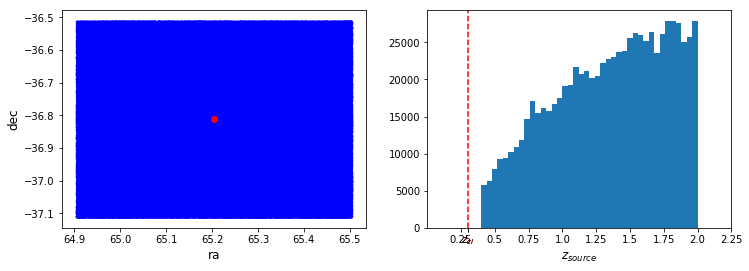

In [134]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(cl.galcat['ra'], cl.galcat['dec'], color='blue', s=1, alpha=0.3)
ax[0].plot(cl.ra, cl.dec, 'ro')
ax[0].set_ylabel('dec', fontsize="large")
ax[0].set_xlabel('ra', fontsize="large")

hist = ax[1].hist(cl.galcat['redshift'], bins=40)[0]
ax[1].axvline(cl.z, c='r', ls='--')
ax[1].set_xlabel('$z_{source}$', fontsize="large")
xt = {t:f'{t}' for t in ax[1].get_xticks() if t!=0}
xt[cl.z] ='$z_{cl}$'
xto = sorted(list(xt.keys())+[cl.z])
ax[1].set_xticks(xto)
ax[1].set_xticklabels(xt[t] for t in xto)
ax[1].get_xticklabels()[xto.index(cl.z)].set_color('red')
plt.xlim(0, max(xto))
plt.show()

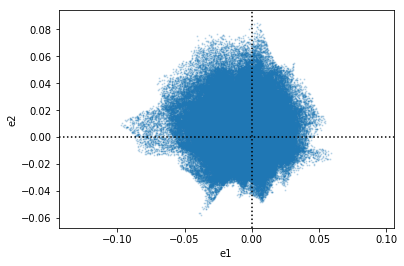

In [135]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(cl.galcat['shear_1'], cl.galcat['shear_2'], s=1, alpha=0.2)
ax1.set_xlabel('e1')
ax1.set_ylabel('e2')
ax1.set_aspect('equal', 'datalim')
ax1.axvline(0, linestyle='dotted', color='black')
ax1.axhline(0, linestyle='dotted', color='black')

### Compute and plot the shear profiles

In [136]:
ra_source_list, dec_source_list, shear1, shear2 = gal_cat['ra'], gal_cat['dec'], gal_cat['shear_1'], gal_cat['shear_2']
theta, g_t, g_x =  compute_shear(ra_lens = cluster_ra, dec_lens = cluster_dec,ra_source_list= ra_source_list, dec_source_list= dec_source_list, shear1 = shear1, shear2 =shear2, add_to_cluster=False)

In [137]:
angsep_units = "radians"
bin_units = "Mpc"

source_seps = convert_units(theta, angsep_units, bin_units, redshift=cl.z, cosmo=cosmo)

bins = make_bins(np.min(source_seps), np.max(source_seps), 20)

# Compute the binned average shears and associated errors
r_avg, gt_avg, gt_err = compute_radial_averages(source_seps, g_t, xbins=bins, error_model='std/n')
r_avg, gx_avg, gx_err = compute_radial_averages(source_seps, g_x, xbins=bins, error_model='std/n')
r_avg, z_avg, z_err = compute_radial_averages(source_seps, gal_cat['redshift'], xbins=bins, error_model='std/n')

profile_table = Table([bins[:-1], r_avg, bins[1:], gt_avg, gt_err, gx_avg, gx_err, z_avg, z_err],\
                      names=('radius_min', 'radius', 'radius_max', 'gt', 'gt_err','gx', 'gx_err', 'z', 'z_err',))


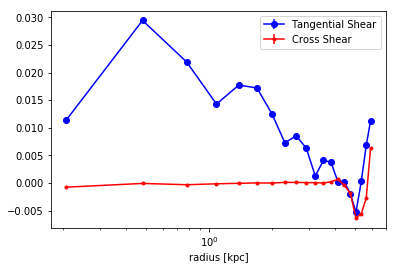

In [138]:
plt.errorbar(profile_table['radius'], profile_table['gt'], yerr= profile_table['gt_err'], fmt='bo-', label="Tangential Shear")
plt.errorbar(profile_table['radius'], profile_table['gx'], yerr= profile_table['gx_err'], fmt='r.-', label="Cross Shear")

plt.xscale('log')

plt.xlabel('radius [kpc]')

plt.legend()

## Compare to model

In [141]:
density_profile_parametrization = 'nfw'
mass_Delta = 200
cluster_mass = cluster_mass
cluster_concentration = 4
z_cl = cluster_z
z_source = 2.

In [142]:
r3d = np.logspace(-1, 1, 100)
cosmo_ccl = m.cclify_astropy_cosmo(cosmo)

In [143]:
gt = m.predict_reduced_tangential_shear(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                                        z_cluster=z_cl, z_source=z_source, cosmo=cosmo_ccl, 
                                        delta_mdef=mass_Delta, 
                                        halo_profile_model=density_profile_parametrization, 
                                        z_src_model='single_plane')
        

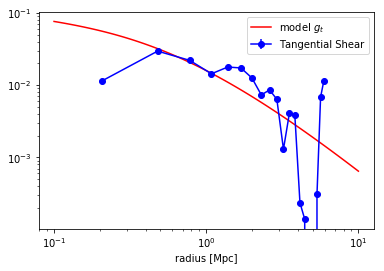

In [144]:
plt.errorbar(profile_table['radius'], profile_table['gt'], yerr= profile_table['gt_err'], fmt='bo-', label="Tangential Shear")

plt.xlabel('radius [Mpc]')

plt.loglog(r3d, gt, 'r', label = 'model $g_t$')

plt.legend()